<a href="https://colab.research.google.com/github/amirhnazerii/VAE_HQ_images/blob/main/Variational_Autoencoder_HQ_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders for High-quality Image Production

__author__ = "Amir Nazeri" 

__copyright__ = "Copyright Spring 2022, The Advanced Neural Network Project @CU-ICAR"

__license__ = "GPL"

__version__ = "2.2.8"

__email__ = "anazeri@clemson.edu"






## Variational Autoencoders Concept
VAE is a generative model that could be used to generate complex datasets such as images of fictional celebrity faces and high-resolution digital artwork. In this project, I built a VAE model to create high-quality images of faces.

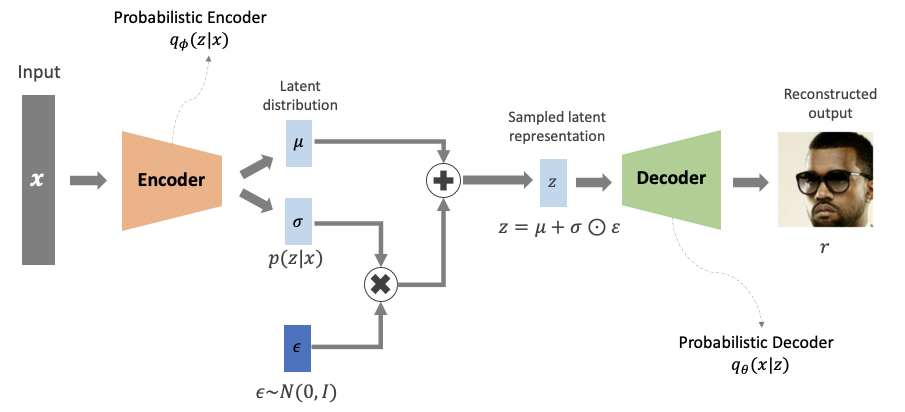

**Dataset**

CelebFaces Attributes Dataset ([CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

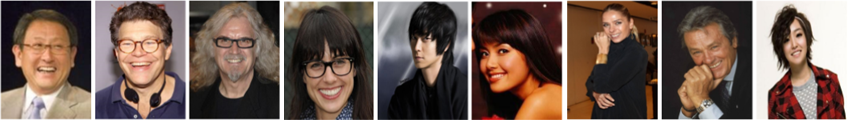

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2259
0 / 1000
200 / 1000
400 / 1000
600 / 1000
800 / 1000
1000 / 2000
1200 / 2000
1400 / 2000
1600 / 2000
1800 / 2000
svmem(total=13653573632, available=9861652480, percent=27.8, used=4778164224, free=2428080128, active=3949621248, inactive=6727868416, buffers=145113088, cached=6302216192, shared=15740928, slab=292421632)
svmem(total=13653573632, available=10288484352, percent=24.6, used=4778180608, free=2427822080, active=3522748416, inactive=7154958336, buffers=145113088, cached=6302457856, shared=15740928, slab=292421632)
2000 / 1000
2050 / 1000
2100 / 1000
2150 / 1000
2200 / 1000
2250 / 1000
Model: "VAE_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
_______________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41


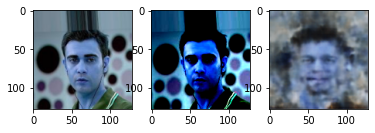

In [ ]:

# Importing Packages
import gc
import psutil
import multiprocessing as mp
import copy
mp.cpu_count()
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose
import keras.backend as K
from keras.layers.merge import add
from sklearn.model_selection import train_test_split
import os
import glob
from time import time,asctime
from random import randint as r
import random

# Load file names of photos
imgs = glob.glob("/content/drive/MyDrive/images/*.jpg")
print(len(imgs))

# create Input vector of 200000 images each of shape (128,128,3) and scale them by dividing them by 255.save this as Y_data and also normalize the Y_data and save it as Z_data to train.
train_y = []
train_y2 = []
for _ in range(0,1000):
  if _%200 == 0:
    print("{} / 1000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  train_y.append(img.astype("float32")/255.0)
for _ in range(1000,2000):
  if _%200 == 0:
    print("{} / 2000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  train_y2.append(img.astype("float32")/255.0)
train_y = np.array(train_y)
train_y2 = np.array(train_y2)
Y_data = np.vstack((train_y,train_y2))
print(psutil.virtual_memory())
del train_y,train_y2
gc.collect()
print(psutil.virtual_memory())

# Normalizing Y_data and save it as Z_data for training
Z_data = copy.deepcopy(Y_data)
Z_data = (Z_data - Z_data.mean())/Z_data.std()

# Test data
test_Y = []
for _ in range(2000,2259):
  if _%50 == 0:
    print("{} / 1000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  test_Y.append(img.astype("float32")/255.0)

# Normalizing Y_data and save it as Z_data for testing  
test_Y = np.array(test_Y)
mean = test_Y.mean()
std = test_Y.std()
test_Z = (test_Y - mean)/std

# Using sampler function in VAE to get the mean and standard deviation
def sampler(layers):
  std_norm = K.random_normal(shape=(K.shape(layers[0])[0], 128), mean=0, stddev=1)
  return layers[0] + layers[1]*std_norm

# Building the Encoder part
stride = 2
inp = Input(shape = (128,128,3))
x = inp
x = Conv2D(32,(2,2),strides = stride,activation = "relu",padding = "same")(x)
x = Conv2D(64,(2,2),strides = stride,activation = "relu",padding = "same")(x)
x = Conv2D(128,(2,2),strides = stride,activation = "relu",padding = "same")(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(256,activation = "relu")(x)
mean_layer = Dense(128,activation = "relu")(x)
sd_layer = Dense(128,activation = "relu")(x)
latent_vector = Lambda(sampler)([mean_layer,sd_layer])
encoder = Model(inp,latent_vector,name = "VAE_Encoder")
encoder.summary()

# Building Decoder part
decoder_inp = Input(shape = (128,))
x = decoder_inp
x = Dense(shape[1]*shape[2]*shape[3],activation = "relu")(x)
x = Reshape((shape[1],shape[2],shape[3]))(x)
x = (Conv2DTranspose(32,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
x = (Conv2DTranspose(16,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
x = (Conv2DTranspose(8,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)
decoder = Model(decoder_inp,outputs,name = "VAE_Decoder")
decoder.summary()

# Connecting the Encoder and Decoder to make the Auto Encoder
autoencoder = Model(inp,decoder(encoder(inp)),name = "Variational_Auto_Encoder")
autoencoder.summary()

# Using adam optimizer and mse loss with accuracy mertics
autoencoder.compile(optimizer = "adam", loss = 'mse', metrics = ["accuracy"])

# Training the Variational Auto Encoder
autoencoder.fit(Z_data, Y_data, batch_size = 20,epochs = 100,validation_split = 0.5)

# Displaying the input,normalized input,VAE output
pred = autoencoder.predict(test_Z)
temp = r(0,259)
print(temp)
plt.subplot(1,3,1)
plt.imshow(test_Y[temp])
plt.subplot(1,3,2)
plt.imshow(test_Z[temp])
plt.subplot(1,3,3)
plt.imshow(pred[temp])




In [ ]:
# The code to take the whole dataset

# Importing Packages
import gc
import psutil
import multiprocessing as mp
import copy
mp.cpu_count()
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose
import keras.backend as K
from keras.layers.merge import add
from sklearn.model_selection import train_test_split
import os
import glob
from time import time,asctime
from random import randint as r
import random

# Load file names of photos
imgs = glob.glob("/content/drive/MyDrive/images/*.jpg")
print(len(imgs))

# create Input vector of 200000 images each of shape (128,128,3) and scale them by dividing them by 255.save this as Y_data and also normalize the Y_data and save it as Z_data to train.
train_y = []
train_y2 = []
for _ in range(0,100000):
  if _%20000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  train_y.append(img.astype("float32")/255.0)
for _ in range(100000,200000):
  if _%20000 == 0:
    print("{} / 200000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  train_y2.append(img.astype("float32")/255.0)
train_y = np.array(train_y)
train_y2 = np.array(train_y2)
Y_data = np.vstack((train_y,train_y2))
print(psutil.virtual_memory())
del train_y,train_y2
gc.collect()
print(psutil.virtual_memory())

# Normalizing Y_data and save it as Z_data for training
Z_data = copy.deepcopy(Y_data)
Z_data = (Z_data - Z_data.mean())/Z_data.std()

# test data
test_Y = []
for _ in range(200000,202599):
  if _%5000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
  test_Y.append(img.astype("float32")/255.0)

# Normalizing Y_data and save it as Z_data for testing
test_Y = np.array(test_Y)
mean = test_Y.mean()
std = test_Y.std()
test_Z = (test_Y - mean)/std

# Using sampler function in VAE to get the mean and standard deviation
def sampler(layers):
  std_norm = K.random_normal(shape=(K.shape(layers[0])[0], 128), mean=0, stddev=1)
  return layers[0] + layers[1]*std_norm

# Building the Encoder part
stride = 2
inp = Input(shape = (128,128,3))
x = inp
x = Conv2D(32,(2,2),strides = stride,activation = "relu",padding = "same")(x)
x = Conv2D(64,(2,2),strides = stride,activation = "relu",padding = "same")(x)
x = Conv2D(128,(2,2),strides = stride,activation = "relu",padding = "same")(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(256,activation = "relu")(x)
mean_layer = Dense(128,activation = "relu")(x)
sd_layer = Dense(128,activation = "relu")(x)
latent_vector = Lambda(sampler)([mean_layer,sd_layer])
encoder = Model(inp,latent_vector,name = "VAE_Encoder")
encoder.summary()

# Building the Decoder part
decoder_inp = Input(shape = (128,))
x = decoder_inp
x = Dense(shape[1]*shape[2]*shape[3],activation = "relu")(x)
x = Reshape((shape[1],shape[2],shape[3]))(x)
x = (Conv2DTranspose(32,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
x = (Conv2DTranspose(16,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
x = (Conv2DTranspose(8,(3,3),strides = stride,activation = "relu",padding = "same"))(x)
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)
decoder = Model(decoder_inp,outputs,name = "VAE_Decoder")
decoder.summary()

# Connecting the Encoder and Decoder to make the Auto Encoder
autoencoder = Model(inp,decoder(encoder(inp)),name = "Variational_Auto_Encoder")
autoencoder.summary()

# Using adam optimizer and mse loss with accuracy mertics
autoencoder.compile(optimizer = "adam", loss = 'mse', metrics = ["accuracy"])

# Training the Variational Auto Encoder
autoencoder.fit(Z_data, Y_data, batch_size = 20,epochs = 100,validation_split = 0.5)

# Displaying the input,normalized input,VAE output
pred = autoencoder.predict(test_Z)
temp = r(0,259)
print(temp)
plt.subplot(1,3,1)
plt.imshow(test_Y[temp])
plt.subplot(1,3,2)
plt.imshow(test_Z[temp])
plt.subplot(1,3,3)
plt.imshow(pred[temp])


